## QF5204: Assignment 2


### 0. Prelim

Option classes; BS pricer; BIN pricer

In [1]:
from enum import Enum
from typing import Optional


PriceType = float


class OptionType(Enum):
    CALL = 1
    PUT = 2


class Option:
    def __init__(self,
                 option_type: OptionType,
                 strike_price: PriceType):
        self.option_type = option_type
        self.strike_price = strike_price

    def is_call(self) -> bool:
        return self.option_type == OptionType.CALL

    def is_put(self) -> bool:
        return self.option_type == OptionType.PUT

    def simple_payoff(self, spot_price: PriceType) -> PriceType:
        if self.is_call():
            return max(spot_price - self.strike_price, 0)
        if self.is_put():
            return max(self.strike_price - spot_price, 0)
        raise NotImplementedError()

    def payoff(self, spot_price: PriceType, time_to_maturity_in_years: float = 0) -> PriceType:
        raise NotImplementedError()

In [2]:
def is_close(x, y, tol=1e-6):
    return abs(x - y) < tol


class EuropeanOption(Option):
    def payoff(self, spot_price: PriceType, time_to_maturity_in_years: float = 0) -> PriceType:
        return 0 if not is_close(time_to_maturity_in_years, 0) else super().simple_payoff(spot_price)


class EuropeanBinaryOption(EuropeanOption):
    def __init__(self, **kwargs):
        self.fixed_payoff = 100
        super().__init__(**kwargs)

    def payoff(self, spot_price: PriceType, time_to_maturity_in_years: float = 0) -> PriceType:
        if not is_close(time_to_maturity_in_years, 0):
            return 0
        return self.fixed_payoff if super().simple_payoff(spot_price) > 0 else 0

In [3]:
import math
from scipy.stats import norm


def bsPricer(spot_price,
             option: EuropeanOption,
             risk_free_rate: float,
             dividend_yield: float,
             volatility: float,
             time_to_maturity_in_years: float) -> PriceType:
    S = spot_price
    K = option.strike_price
    r = risk_free_rate
    q = dividend_yield

    sigma = volatility
    tau = time_to_maturity_in_years

    # Compute d +/-
    sd = sigma * (tau ** 0.5)

    d1 = (math.log(S / K) + (r - q) * tau)/sd + sd/2
    d2 = d1 - sd

    d1_cdf = norm.cdf(d1)
    d2_cdf = norm.cdf(d2)

    # Discount factor and dividends
    D = math.exp(-r*tau)
    Q = math.exp(-q*tau)

    if isinstance(option, EuropeanBinaryOption):
        # Cash or nothing
        value = D*d2_cdf
        if option.is_put():
            # P = D - C
            value = D - value
        return value * option.fixed_payoff

    value = S*Q*d1_cdf - K*D*d2_cdf
    if option.is_put():
        # P = C - SQ + KD
        value = value - S*Q + K*D

    return value

In [4]:
from typing import Callable

# Note: there are alternate calibrators like Jarrow-Rudd and Tian.
def crr_calibrator(r: float, vol: float, t: float) -> tuple[float, float, float]:
    b = math.exp((r + vol*vol) * t) + math.exp(-r*t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (u*math.exp(r*t) - 1) / (u*u - 1) if u != 1 else 1/2
    return (u, 1/u, p)


def binomialPricer(spot_price: float,
                   option: Option,
                   risk_free_rate: float,
                   dividend_yield: float,
                   volatility: float,
                   time_to_maturity_in_years: float,
                   calibrator: Callable = crr_calibrator,
                   num_steps: int = 50) -> PriceType:

    r = risk_free_rate
    t = time_to_maturity_in_years / num_steps

    u, d, p = calibrator(r - dividend_yield, volatility, t)

    S = spot_price
    value = [option.payoff((u ** (num_steps - i)) * (d ** i) * S) for i in range(num_steps + 1)]

    discount_factor = math.exp(-r*t)
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            current_time_to_maturity = time_to_maturity_in_years - i*t

            current_payoff = option.payoff((u ** (i - j)) * (d ** j) * S, current_time_to_maturity)
            expected_payoff_upon_continuation = discount_factor * (p*value[j] + (1 - p)*value[j + 1])

            # Note: for European options, current_payoff is 0
            value[j] = max(current_payoff, expected_payoff_upon_continuation)

    return value[0]

### 1. Trinomial Tree

Implement `trinomialPricerAnchor`. Instead of taking the parameter $\lambda$ as in our example code, this function takes a discontinuity K and anchors a tree node to K by tuning $\lambda$ inside the pricer.
Note that there are many ways to adjust $\lambda$.
One example is to construct the tree with $\lambda = \sqrt{3}$ first, find the node closest to $K$, then adjust $\lambda$ such that the node falls on $K$.
But you are free to define your own way to achieve this.

`compute_lambda` is implemented as described above. The closest node if found directly through rounding assuming $\lambda_0 = \sqrt{3}$, instead of constructing a full tree.

In [21]:
def compute_lambda(K: float, S: float, sd: float, num_steps: int, lam0: float) -> float:
    if K == S:
        # Choose default
        return lam0

    # S * (u ** up_minus_down) = K
    # up_minus_down * lam = 1/sd * log(K/S) = G
    G = 1/sd * math.log(K / S)

    # Use lam0 to compute up_minus_down rounded to nearest integer that is not 0
    up_minus_down = G / lam0
    rounded_up_minus_down = round(up_minus_down) if abs(up_minus_down) > 0.5 else (1 if up_minus_down > 0 else -1)

    # Use rounded_up_minus_down to compute lam
    return max(G / rounded_up_minus_down, 1)

`calibrator` uses the computed $\lambda$ to compute u, pu, pm and pd by matching the first and second moments.

`trinomialPricerAnchor` is written similar to the `binomialPricer`. `compute_lambda` and `calibrator` are used to compute parameters of the tree. The price at node i at step n is $Su^{n - i}$, and the number of nodes at step n is $2n + 1$.

In [6]:
def calibrator(r: float, vol: float, t: float, lam: float) -> tuple[float, float, float, float]:
    sd = vol * (t ** 0.5)
    u = math.exp(lam * sd)

    dd = (sd/(4 * lam)) * (2*r/(vol*vol) - 1)
    pm = 1 - 1/(lam*lam)
    pu = (1 - pm)/2 + dd
    pd = (1 - pm)/2 - dd

    return u, pu, pm, pd

In [25]:
def trinomialPricerAnchor(spot_price: float,
                          option: Option,
                          risk_free_rate: float,
                          dividend_yield: float,
                          volatility: float,
                          time_to_maturity_in_years: float,
                          lambda0: float = 3**0.5,
                          anchor: Optional[float] = None,
                          num_steps: int = 100) -> PriceType:

    t = time_to_maturity_in_years / num_steps
    sd = volatility * (t ** 0.5)
    S = spot_price

    lam = compute_lambda(anchor or S, S, sd, num_steps, lambda0)

    r = risk_free_rate
    u, pu, pm, pd = calibrator(r - dividend_yield, volatility, t, lam)

    value = [option.payoff((u ** (num_steps - i)) * S) for i in range(2*num_steps + 1)]

    discount_factor = math.exp(-r*t)
    for i in range(num_steps - 1, -1, -1):
        for j in range(2*i + 1):
            current_time_to_maturity = time_to_maturity_in_years - i*t

            current_payoff = option.payoff((u ** (i - j)) * S, current_time_to_maturity)
            expected_payoff_upon_continuation = discount_factor * (pu*value[j] + pm*value[j + 1] + pd*value[j + 2])

            value[j] = max(current_payoff, expected_payoff_upon_continuation)

    return value[0]

Plot the pricing errors of this trinomial tree pricer with the market and strike below, for number of tree steps from 10 to 300 (similar to our binomial tree test cases).
Use a European Call option and a Binary Call option as test trades.

In [8]:
K = 105
S, r, q, vol, t = 100, 0.01, 0, 0.2, 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot(step_range, lines, true_value, title):
    for line, label in lines:
        plt.plot(step_range, np.abs(line - true_value), label=label)

    plt.yscale('log')
    plt.xlabel("num_steps")
    plt.ylabel("price diff with BS")
    plt.title(title)
    plt.legend()
    plt.show()


for option in [
    EuropeanOption(option_type=OptionType.CALL, strike_price=K),
    EuropeanBinaryOption(option_type=OptionType.CALL, strike_price=K),
]:
    step_range = range(10, 301)
    bs_pri = bsPricer(S, option, r, q, vol, t)
    bin_pri = np.array([binomialPricer(S, option, r, q, vol, t, num_steps=num_steps) for num_steps in step_range])
    tri_pri_l1 = np.array([trinomialPricerAnchor(S, option, r, q, vol, t, 1, None, num_steps) for num_steps in step_range])
    tri_pri_l14 = np.array([trinomialPricerAnchor(S, option, r, q, vol, t, 2**0.5, None, num_steps) for num_steps in step_range])
    tri_pri_l17 = np.array([trinomialPricerAnchor(S, option, r, q, vol, t, 3**0.5, None, num_steps) for num_steps in step_range])
    tri_pri_with_anchor = np.array([trinomialPricerAnchor(S, option, r, q, vol, t, anchor=K, num_steps=num_steps) for num_steps in step_range])
    plot(
        step_range,
        [(bin_pri, "bin"),
         (tri_pri_l1, "tri_lam_l1"),
         (tri_pri_l14, "tri_lam_l14"),
         (tri_pri_l17, "tri_lam_l17"),
         (tri_pri_with_anchor, "tri_anc")],
        bs_pri,
        f"{type(option)}; S = {S}; K = {K}"
    )

The difference is attributed to the parameter $\lambda$. EuropeanBinaryOption has a fixed payoff of 100.

### 2. Strike from Delta

Assuming forward delta convention, implement below function ```strikeFromdelta``` that calculates the strike from a given delta.
You may use the ```fwdDelta``` function below.

Forward delta is given by $$\Delta_{C} = N(d_+); \Delta_{P} = -N(-d_+) = N(d_+) - 1$$ where 
$$d_+ = \frac{ln(F/K) + \frac{1}{2}sd^2}{sd}, sd = \sigma\sqrt{T}$$

In fact, K can be computed explicitly:

In [10]:
def strikeFromDeltaExplicit(S, r, q, T, vol, delta, option_type):
    assert option_type in [OptionType.CALL, OptionType.PUT]

    if delta < 0:
        delta = -delta

    F = S * math.exp((r - q) * T)
    sd = vol * (T ** 0.5)
    d1 = norm.ppf(delta if option_type == OptionType.CALL else 1 - delta)

    return F / math.exp((d1 - sd/2) * sd)

Alternatively, `x = K` is the root of the equation `fwdDelta(x, ...) - given_delta = 0`. A basic bisection routine, `scipy.optimize.bisect`, is used to find the root but any other algorithm works too.

In [11]:
from scipy import optimize


def fwdDelta(fwd, sd, strike, option_type):
    # NB: Returns |delta|
    assert option_type in [OptionType.CALL, OptionType.PUT]

    d1 = math.log(fwd/strike) / sd + sd / 2
    return norm.cdf(d1) if option_type == OptionType.CALL else 1 - norm.cdf(d1)


def strikeFromDeltaRootFind(S, r, q, T, vol, delta, option_type):
    if delta < 0:
        delta = -delta

    F = S * math.exp((r - q) * T)
    sd = vol * (T ** 0.5)
    return optimize.bisect(lambda K: fwdDelta(F, sd, K, option_type) - delta, 1, F*F)

Do the 2 functions agree on the strike? Does the computed strike have forward delta that is same as the given delta?

In [12]:
S, r, q, t, vol = 100, 0.1, 0, 1, 0.2
F, sd = S * math.exp((r - q) * t), vol * (t ** 0.5)

N = 100
for d in range(1, N):
    delta = d/N
    K1C = strikeFromDeltaExplicit(S, r, q, t, vol,  delta, OptionType.CALL)
    K2C = strikeFromDeltaRootFind(S, r, q, t, vol,  delta, OptionType.CALL)
    assert is_close(K1C, K2C)

    K1P = strikeFromDeltaExplicit(S, r, q, t, vol, -delta, OptionType.PUT)
    K2P = strikeFromDeltaRootFind(S, r, q, t, vol, -delta, OptionType.PUT)
    assert is_close(K1P, K2P)

    deltaC = fwdDelta(F, sd, K1C, OptionType.CALL)
    assert is_close(deltaC, delta)

    deltaP = fwdDelta(F, sd, K1P, OptionType.PUT)
    assert is_close(deltaP, delta)

In [13]:
def strikeFromDelta(S, r, q, T, vol, delta, option_type):
    return strikeFromDeltaExplicit(S, r, q, T, vol, delta, option_type)

### 3. Smile from Marks

Implement ```smilefromMarks``` function below, it take the time to maturity $T$, current spot price $S$, risk free and dividend rate $r$ and $q$,
ATM volatility, BF25, RR25, BF10, RR10 quotes, returns a CubicSpline interpolated smile for this pillar. We assume ATM forward convention. 
You may use the Smile class provided below.   

In [14]:
from scipy.interpolate import CubicSpline


class Smile:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes + [1.1*strikes[-1] - 0.1*strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1]-vols[-2])/10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        # scipy cubicspline bc_type is confusing, extrapolate by ourselves
        if k < self.strikes[0]:
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        return self.cs(k)

Smile strangle, BF, and Risk Reversal, RR are given by the following equations.

$$
\begin{align}
BF_{\Delta} &= \frac{1}{2}(\sigma_{\Delta_{C}} + \sigma_{\Delta_{P}}) - \sigma_{ATM} \\
RR_{\Delta} &= \sigma_{\Delta_{C}} - \sigma_{\Delta_{P}}
\end{align}
$$

Solving for $\sigma_{\Delta_C}$ and $\sigma_{\Delta_P}$,

$$
\begin{align}
\sigma_{\Delta_{C}} &= \sigma_{ATM} + BF_{\Delta} + \frac{1}{2}RR_{\Delta} \\
\sigma_{\Delta_{P}} &= \sigma_{ATM} + BF_{\Delta} - \frac{1}{2}RR_{\Delta} \\
\end{align}
$$

Compute strike, K, from above $(\Delta, \sigma_{\Delta})$ pairs. Finally, interpolate using `CubicSpline` to get the volatility smile.

In [15]:
def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):
    call_vol10 = atmvol + bf10 + rr10/2
    CK10 = strikeFromDelta(S, r, q, T, call_vol10, 0.1, OptionType.CALL)

    call_vol25 = atmvol + bf25 + rr25/2
    CK25 = strikeFromDelta(S, r, q, T, call_vol25, 0.25, OptionType.CALL)

    put_vol10 = atmvol + bf10 - rr10/2
    PK10 = strikeFromDelta(S, r, q, T, put_vol10, -0.10, OptionType.PUT)

    put_vol25 = atmvol + bf25 - rr25/2
    PK25 = strikeFromDelta(S, r, q, T, put_vol25, -0.25, OptionType.PUT)

    K_atm = F = S * math.exp((r - q) * T)
    strikes = [PK10, PK25, K_atm, CK25, CK10]
    vols = [put_vol10, put_vol25, atmvol, call_vol25, call_vol10]

    return Smile(strikes, vols)

With ```smileFromMarks```, we can prepare our implied volatility surface from input marks.

In [16]:
import bisect


class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)

        prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
        nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
        w = (nextT - t) / (nextT - prevT)
        prevVar = prevVol * prevVol * prevT
        nextVar = nextVol * nextVol * nextT
        return math.sqrt((w * prevVar + (1-w) * nextVar)/t)
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

Plot the test implied volatility surface using below test functions.

In [17]:
def createTestImpliedVol(S, r, q):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface():
    S, r, q = 1.25805, 0.01, 0.003
    iv = createTestImpliedVol(S, r, q)
    tStart, tEnd = 0.02, 0.5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, OptionType.PUT)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, OptionType.CALL)
    ks = np.arange(kmin, kmax, 0.01)

    vs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    plt.show()

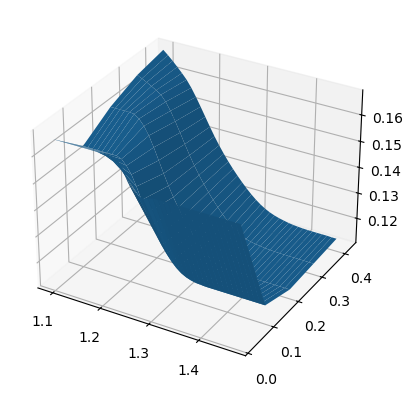

In [18]:
plotTestImpliedVolSurface()